## Обзор данных и предобработка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import sys
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools

### Знакомство с данными

In [2]:
# открываем файл с данными
df = pd.read_csv('/datasets/gym_churn.csv')

# выводим 5 строк для ознакомления
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
# описание данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

В нашем распоряжении таблица, которая содержит:
1. Данные клиента за предыдущий до проверки факта оттока месяц:
* `gender` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
* `Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).
2. Информацию на основе журнала посещений, покупок и информацию о текущем статусе абонемента клиента:
* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятий;
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
3. `Churn` — факт оттока в текущем месяце.

<div style="border:solid green 1px; padding: 10px">

Пропусков в данных нет. Названия столбцов не в одном регистре. Типы данных везде соответствуют содержанию.

Приведем названия столбцов к нижнему регистру и проверим данные на дубликаты.

In [4]:
# приведение столбцов к нижнему регистру
df.columns = df.columns.str.lower()

# проверка на дубликаты
df.duplicated().sum()

0


### Исследование данных

___
**Изучим средние значения и стандартные отклонения признаков:**

In [5]:
df[['contract_period', 'age', 'avg_additional_charges_total',
     'month_to_end_contract', 'lifetime', 'avg_class_frequency_total',
     'avg_class_frequency_current_month']].describe()

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,4.681250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052
std,4.549706,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906
min,1.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,1.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003
50%,1.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574
75%,6.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336
max,12.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783



В столбцах `contract_period` и  `month_to_end_contract` большое отклонение среднего от медианы. Посмотрим гистограмму:

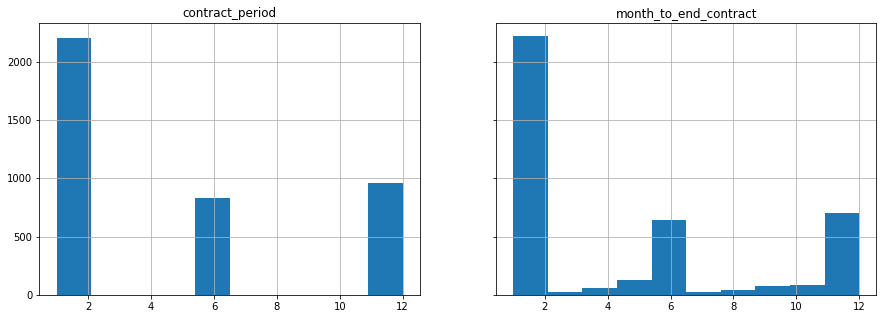

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.grid()
ax1.hist(df['contract_period'])
ax1.set_title('contract_period')
ax2.grid()
ax2.hist(df['month_to_end_contract'])
ax2.set_title('month_to_end_contract');

<div style="border:solid green 1px; padding: 10px">
 
Больше всего значений для обоих столбцов - 1 месяц.

___
**Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался:**

In [7]:
df.groupby('churn')[['contract_period', 'age', 'avg_additional_charges_total',
     'month_to_end_contract', 'lifetime', 'avg_class_frequency_total',
     'avg_class_frequency_current_month']].describe()

contract_period                                                    age  \
                count      mean       std  min  25%  50%   75%   max   count   
churn                                                                          
0              2939.0  5.747193  4.716942  1.0  1.0  6.0  12.0  12.0  2939.0   
1              1061.0  1.728558  2.132371  1.0  1.0  1.0   1.0  12.0  1061.0   

                                                          \
            mean       std   min   25%   50%   75%   max   
churn                                                      
0      29.976523  3.009933  19.0  28.0  30.0  32.0  41.0   
1      26.989632  2.895163  18.0  25.0  27.0  29.0  38.0   

      avg_additional_charges_total                                   \
                             count        mean        std       min   
churn                                                                 
0                           2939.0  158.445715  99.801599  0.171862   
1                           1061.0  115.082899  77.696419  0.148205   

                                                    month_to_end_contract  \
             25%         50%         75%        max                 count   
churn                                                                       
0      76.920993  149.881171  224.448274  552.59074                2939.0   
1      50.629127  103.814686  165.616858  425.53522                1061.0   

                                                     lifetime            \
           mean       std  min  25%  50%   75%   max    count      mean   
churn                                                                     
0      5.283089  4.363522  1.0  1.0  6.0  10.0  12.0   2939.0  4.711807   
1      1.662582  1.964593  1.0  1.0  1.0   1.0  12.0   1061.0  0.990575   

                                          avg_class_frequency_total            \
            std  min  25%  50%  75%   max                     count      mean   
churn                                                                           
0      3.874780  0.0  2.0  4.0  6.0  31.0                    2939.0  2.024876   
1      1.110799  0.0  0.0  1.0  1.0   9.0                    1061.0  1.474995   

                                                              \
            std  min       25%       50%       75%       max   
churn                                                          
0      1.016006  0.0  1.283137  2.043252  2.732944  6.023668   
1      0.694705  0.0  1.010771  1.491187  1.956438  3.478646   

      avg_class_frequency_current_month                                     \
                                  count      mean       std  min       25%   
churn                                                                        
0                                2939.0  2.027882  1.018994  0.0  1.297021   
1                                1061.0  1.044546  0.770237  0.0  0.421337   

                                     
            50%       75%       max  
churn                                
0      2.046697  2.740648  6.146783  
1      0.979445  1.588576  3.540271

<div style="border:solid green 1px; padding: 10px">
    
Не наблюдается сильного отклонения в данных. Клиентов не попавших в отток (`churn = 0`) значительно больше.

___
**Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток):**

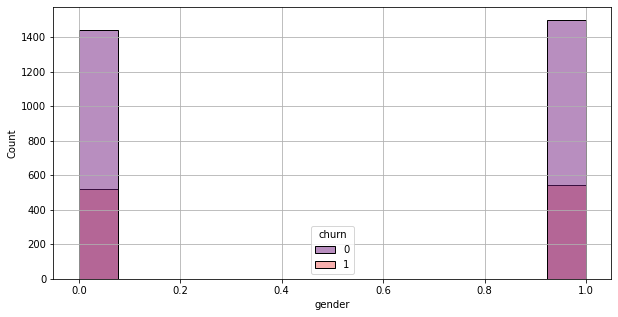

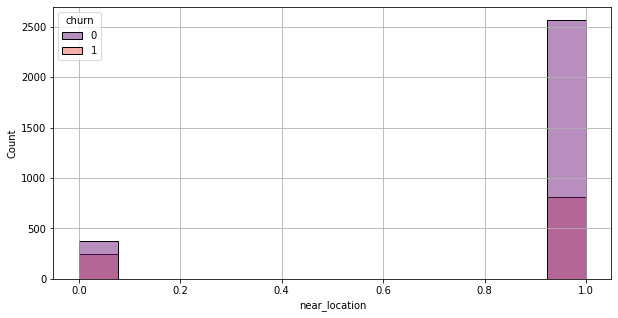

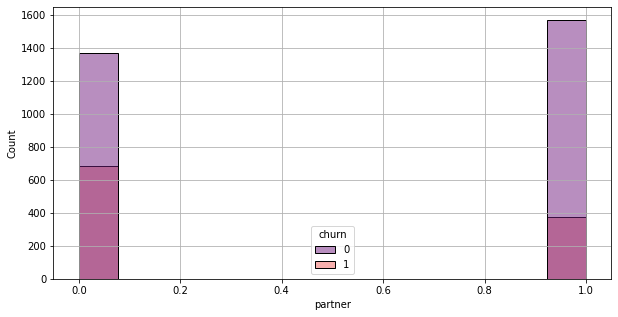

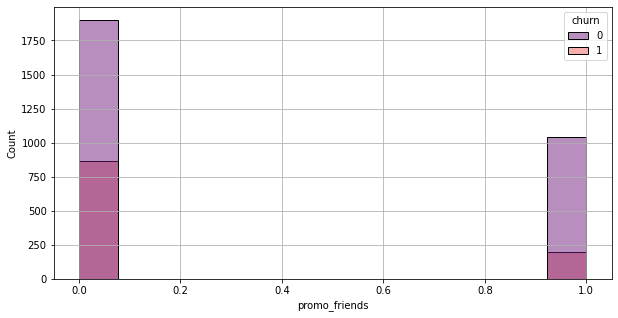

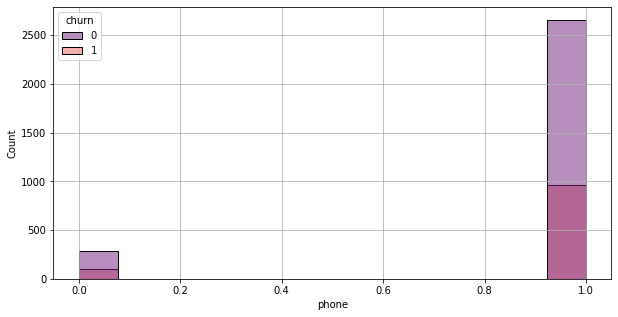

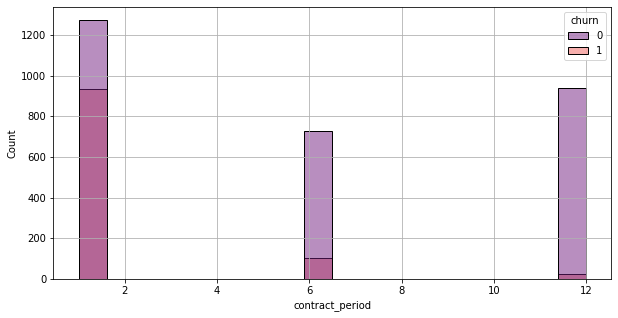

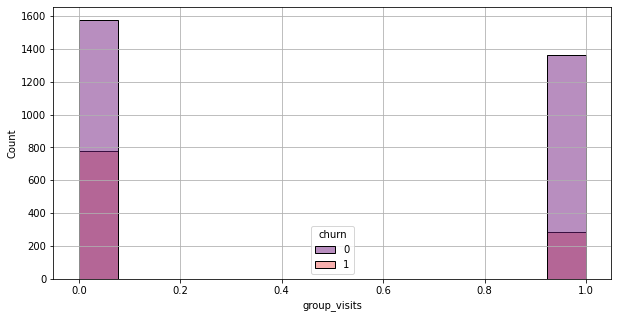

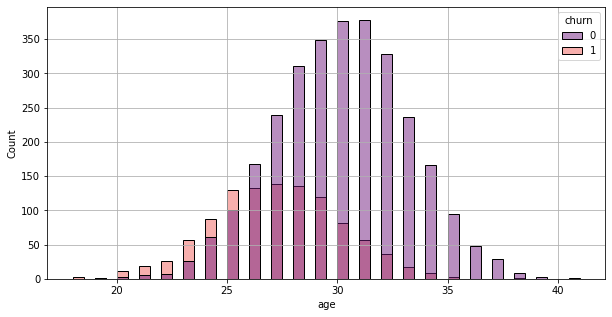

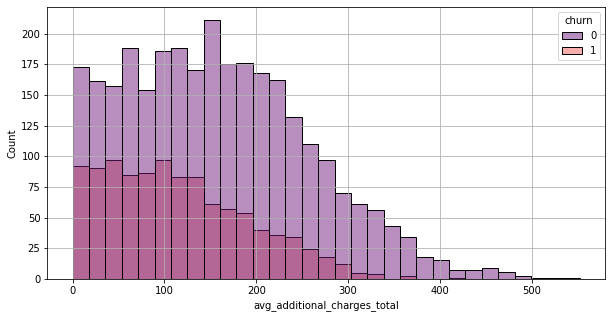

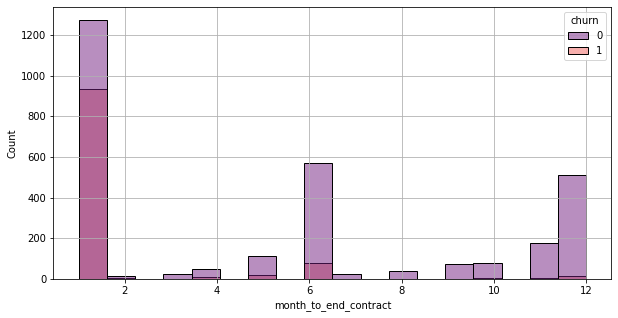

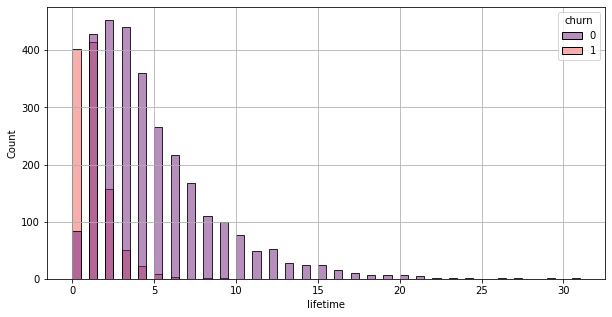

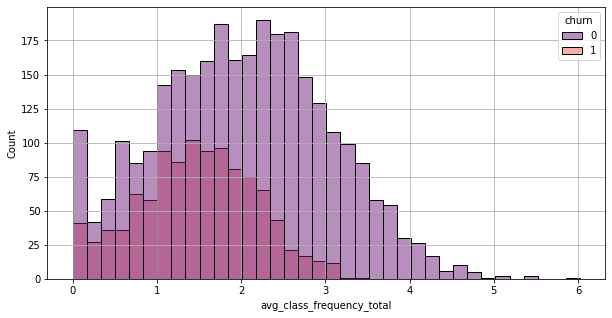

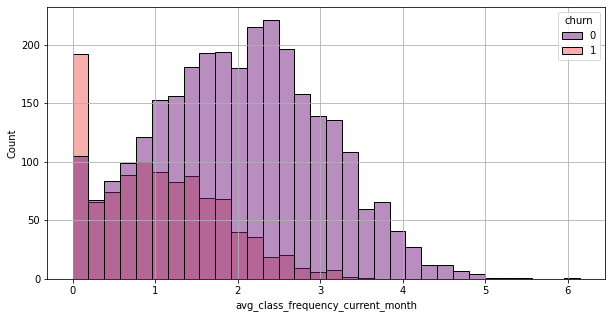

In [8]:
#построим попарные столбчатые гистограммы признак-целевая переменная для каждого признака
for col in df.drop('churn', axis=1).columns:
    plt.figure(figsize=(10, 5))
    plt.grid()
    sns.histplot(data=df, x=df[col], hue='churn', palette = 'magma')
    plt.show()

<div style="border:solid green 1px; padding: 10px">

На гистограммах видно тоже, что и при группировке - не "оттекших" клиентов больше.

В двух значениях `churn` распредение:
    
- по признаку пола примерно одинаково;
- по признаку близости от дома/работы сильно выше;
- сотрудников партнеров клуба больше среди клиентов;
- клиентов по промо наоборот меньше;
- очень мало значений с отсутствием телефона клиента;
- клиенты чаще оформляют месячные абонементы, реже на пол года;
- клиенты чаще не посещают групповые занятия;
- пик значений по признаку возраста в районе 30 лет для оставшихся и в районе 27-28 для оттекших;
- для выручки от сопуствующих услух гистограмма скошена и меет хвост справа;
- у большинства клиентов до окончания абонемента 1 месяц;
- по времени от первого обращения в фитнес для оставшихся клиентов пик значения в районе 2 месяцев, для оттекших - одного;
- по средней частоте посещений в неделю за все время и за прошлый месяц - это 2-3 раза для оставшихся и 1-2 для оттекших, плюс есть небольшой хвост в право.

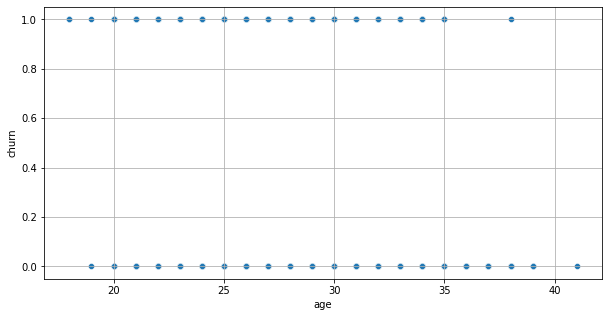

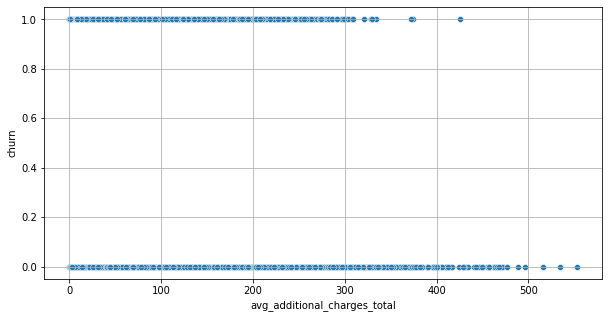

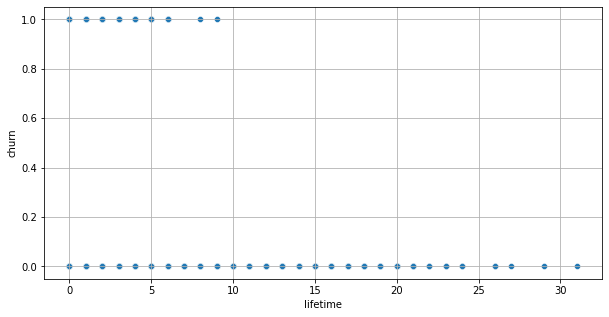

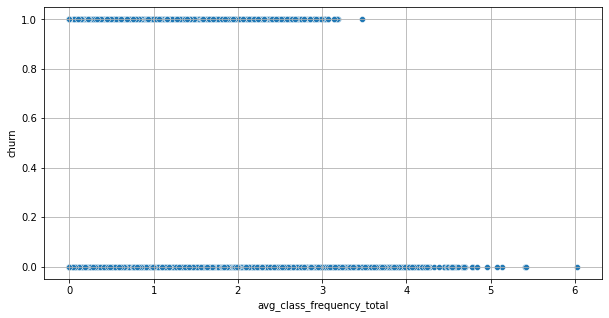

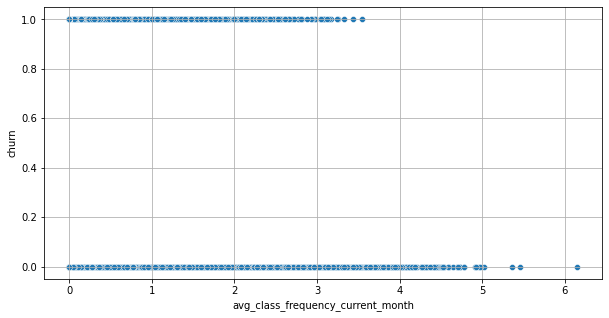

In [9]:
#построим попарные диаграммы рассеяния признак-целевая переменная для каждого признака
for col in df[['age', 'avg_additional_charges_total', 'lifetime',
               'avg_class_frequency_total', 'avg_class_frequency_current_month']].columns:
    plt.figure(figsize=(10, 5))
    plt.grid()
    sns.scatterplot(x=df[col], y=df['churn'])
    plt.show()

<div style="border:solid green 1px; padding: 10px">
    
На диаграммах также видно несколько выбросов в значениях `avg_class_frequency_total`, `avg_additional_charges_total`, `avg_class_frequency_current_month` и по значениям столбца `lifetime` видно, что сильно разнится количество значений.

___
**Построим матрицу корреляций и отобразим её на тепловой карте:**

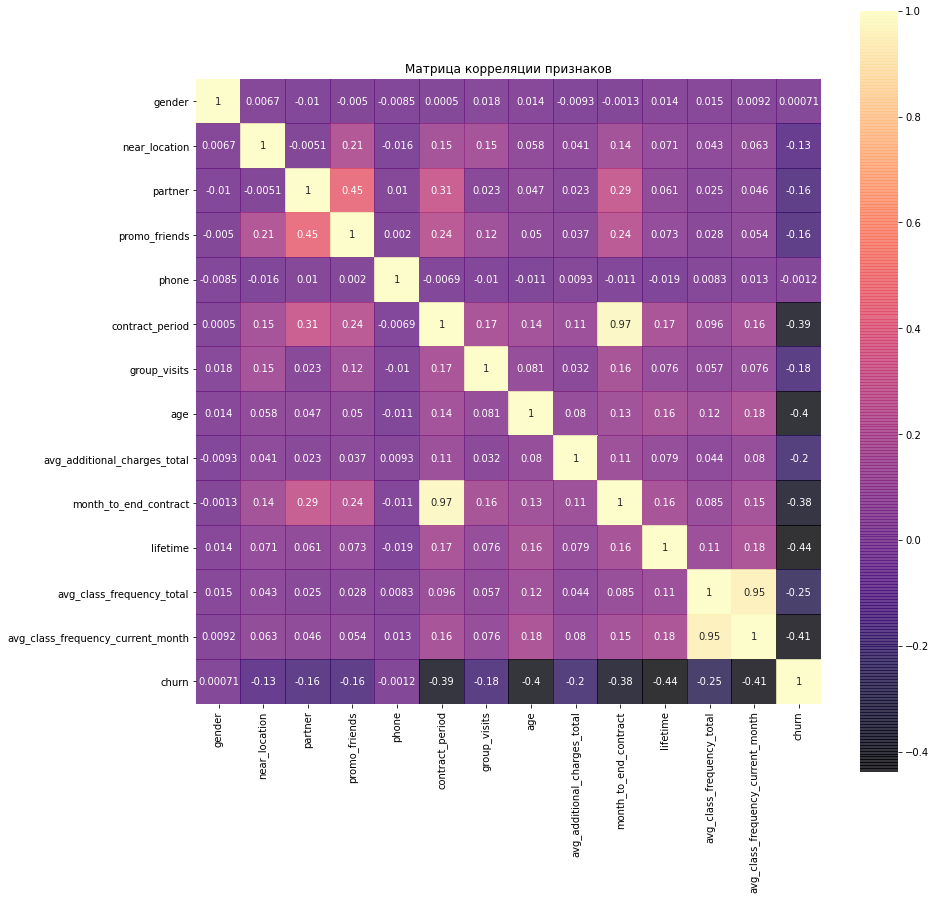

In [10]:
# строим матрицу 
df_corr = df.corr()

# рисуем heatmap
plt.figure(figsize=(14, 14))
sns.heatmap(df_corr, square=True, annot=True, alpha=0.8, cmap='magma')
plt.title('Матрица корреляции признаков')
plt.show()

<div style="border:solid green 1px; padding: 10px">
    
Сильная корреляция признаков `month_to_end_contract` и `contract_period`, а также между `avg_class_frequency_current_month` и `avg_class_frequency_total`, что может быть из-за близости по смыслу. Это мультиколлинеарность и от нее лучше избавляться перед обучением линейных моделей.
    
Между остальными признаков сильной зависимости (ни прямой, ни обратной) нет.

In [21]:
# уберем мультиколлинеарные признаки
df_for_models = df.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis=1)
df_for_models.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.205633,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.113884,0


## Прогноз вероятности оттока (на уровне следующего месяца) для каждого клиента

Построим модель прогнозирования оттока клиентов (бинарной классификации), где целевой признак — факт оттока клиента в следующем месяце (столбец `churn` датафрейма):

1. Разобъем данные на обучающую (тестовую) и валидационную выборку в соотношении 80/20.
2. Обучим модель на тестовой выборке двумя способами:
    - логистической регрессией,
    - случайным лесом.
3. Оценим метрики `accuracy`, `precision` и `recall` для обеих моделей на валидационной выборке. Сравните по ним модели и выясним какая модель показала себя лучше.

### Разбиение данных на выборки

In [16]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df_for_models.drop(columns=['churn'])
y = df_for_models['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# проверим размеры выборок после разделения
print(X_train.shape,  X_test.shape)

(3200, 11) (800, 11)


In [17]:
# создадим объект класса StandardScaler, обучим и одновременно трансформируем матрицу для обучающей выборки
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

###  Обучение моделей

In [18]:
# список моделей
models = [LogisticRegression(solver='liblinear', random_state=0), RandomForestClassifier(random_state=0)]

# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
        model = m
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print('accuracy: {:.2f}, precision: {:.2f}, recall: {:.2f}'.format(
            accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)))

### Оценка метрик

In [19]:
# цикл, который выводит метрики выборки по списку моделей
for i in models:
    print(i)
    make_prediction(m=i, X_train=X_train_st, y_train=y_train, X_test=X_test_st, y_test=y_test)

LogisticRegression(random_state=0, solver='liblinear')
accuracy: 0.90, precision: 0.79, recall: 0.81
RandomForestClassifier(random_state=0)
accuracy: 0.89, precision: 0.79, recall: 0.76


<div style="border:solid green 1px; padding: 10px">

Мы получили почти одинаковый результат: доля верно угаданных ответов (`accuracy`) в 0.90/0.89 для двух моделей это очень хорошо, первая модель совсем немного лучше также и по метрике полноты (`recall`) - 0.81 против 0.76.

## Формирование типичных портретов клиентов

Уберем столбец с оттоком `churn` и разобъем клиентов на группы (кластеры).

1. Построим матрицу расстояний на стандартизованной матрице признаков и нарисуем дендрограмму. На основании полученного графика решим какое количество кластеров можно выделить.
2. Обучим модель кластеризации на основании алгоритма `K-Means` и спрогнозирем кластеры клиентов. Посмотрим на средние значения признаков для кластеров. Построим распределения признаков для кластеров.
3. Для каждого полученного кластера посчитаем долю оттока. Посмотрим отличаются ли они по доле оттока и какие кластеры склонны к оттоку, а какие — надёжны.

### Матрица расстояний и дендрограмма

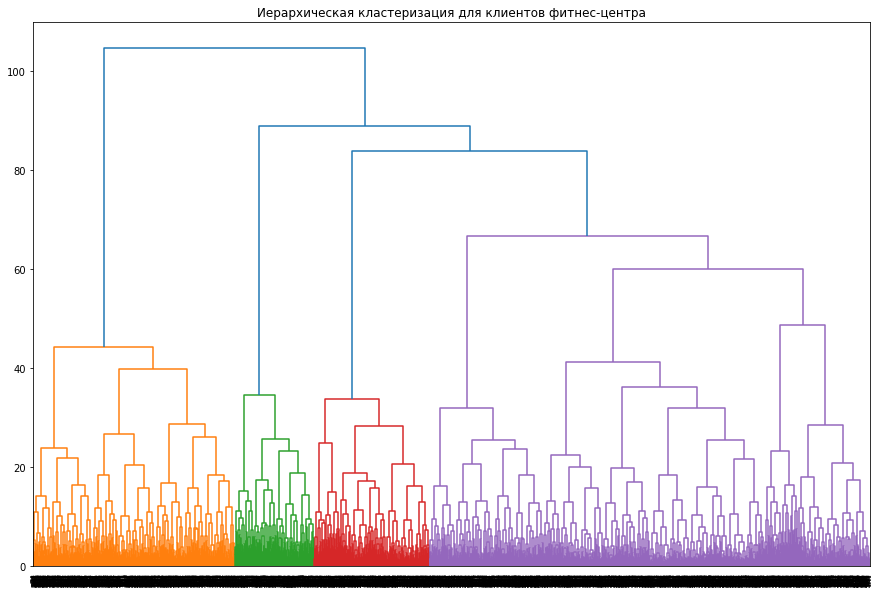

In [14]:
# стандартизация данных 
X_st = scaler.fit_transform(X)

# матрица расстояний
linked = linkage(X_st, method = 'ward') 

# дендрограмма
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для клиентов фитнес-центра')
plt.show() 

<div style="border:solid green 1px; padding: 10px">


На дендрограмме 5 разных цветов, можно выделелить 5 кластеров.

### Обучение модели K-mean и разделение клиентов на группы. Средние значения и распределение признаков для кластеров

In [23]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters=5, random_state=0)

# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_st)

# сохраняем метки кластера в поле нашего датасета
df['customer_group'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
display(df.drop('churn', axis=1).groupby('customer_group').mean())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
customer_group,,,,,,,,,,,,,
0,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,2.853832,3.060606,1.770413,1.606619
1,0.488571,0.995238,0.955238,0.892381,1.0,7.660952,0.458095,29.543810,155.861428,6.988571,4.380952,1.978963,1.933736
2,0.505300,1.000000,0.238516,0.059187,1.0,2.819788,0.000000,28.770318,143.383993,2.650177,3.343640,1.800647,1.645965
3,0.544202,1.000000,0.250287,0.079219,1.0,4.528129,1.000000,29.536165,148.088897,4.165327,3.761194,1.941342,1.845911
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


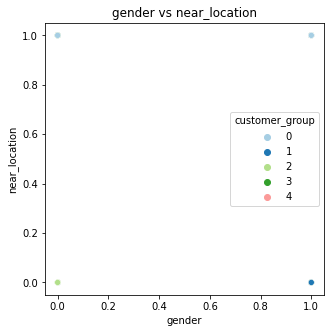

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


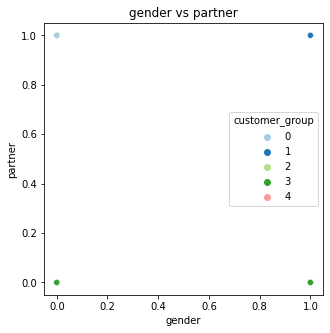

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


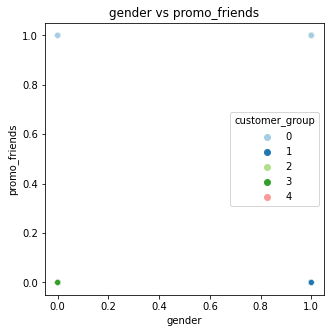

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


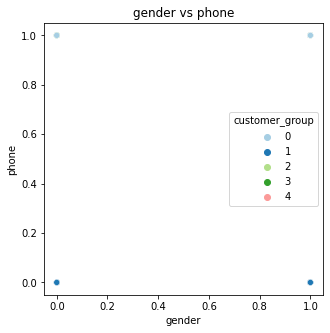

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


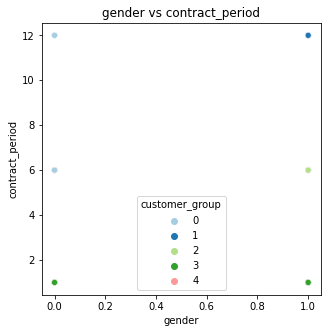

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


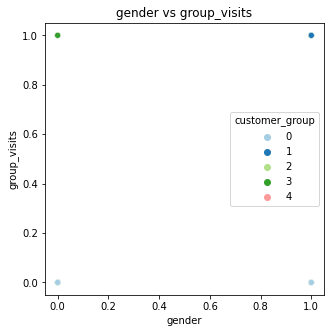

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


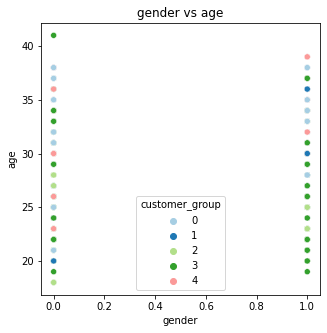

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


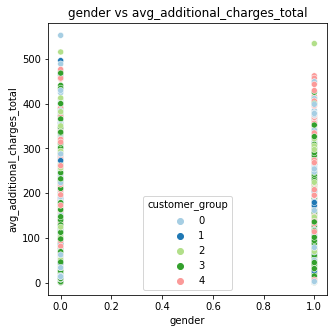

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


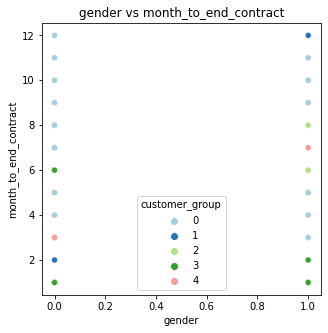

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


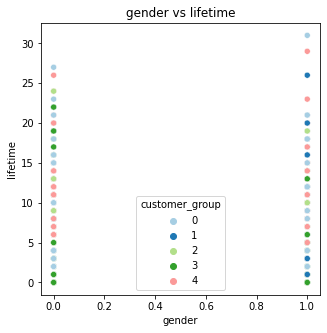

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


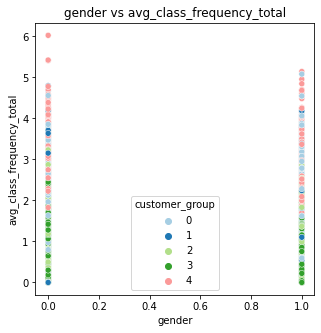

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


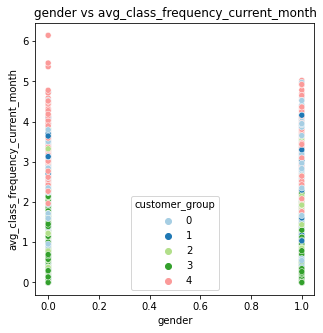

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


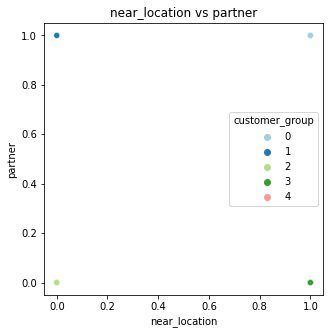

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


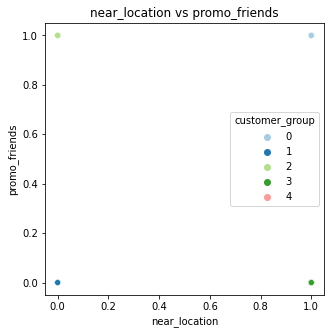

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


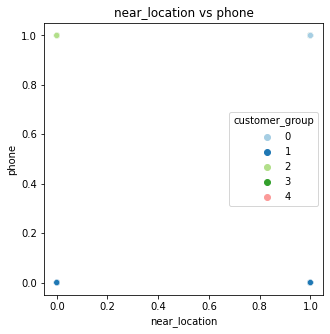

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


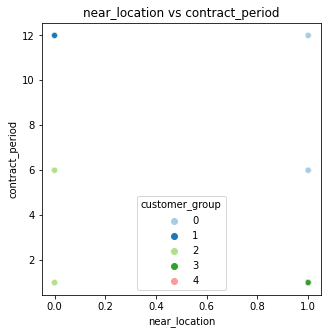

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


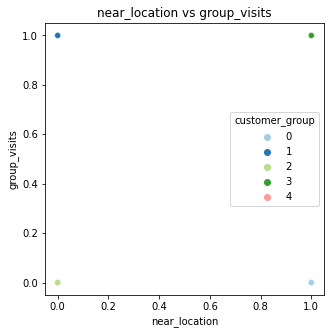

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


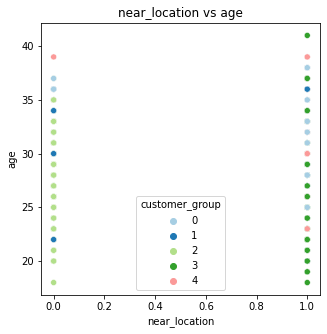

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


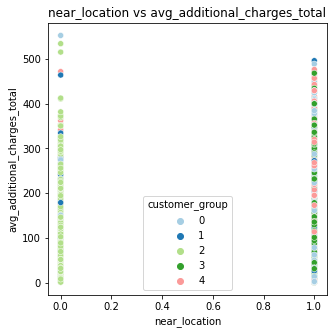

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


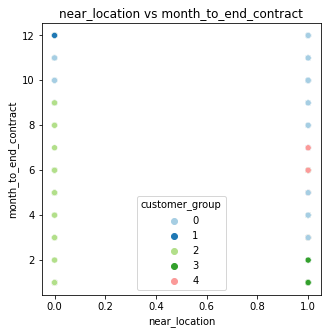

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


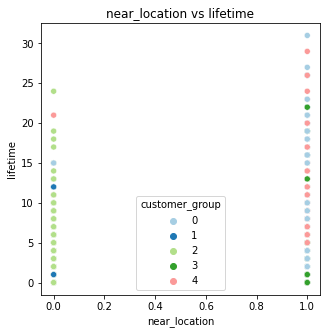

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


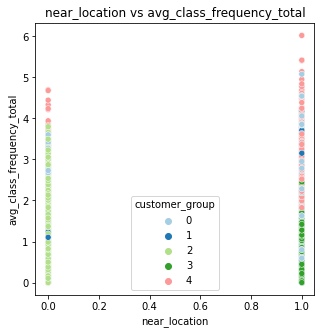

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


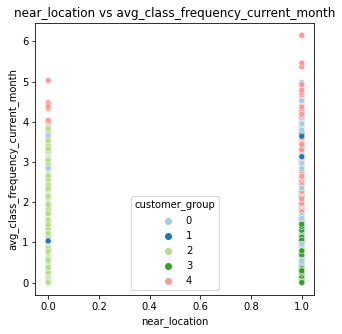

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


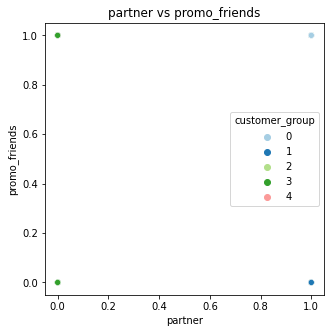

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


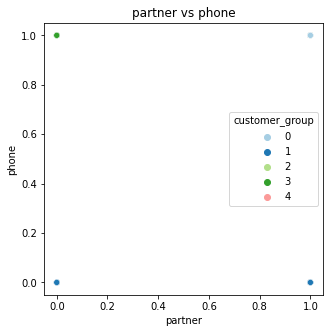

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


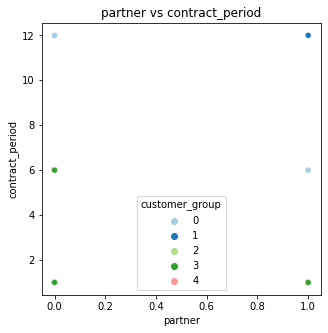

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


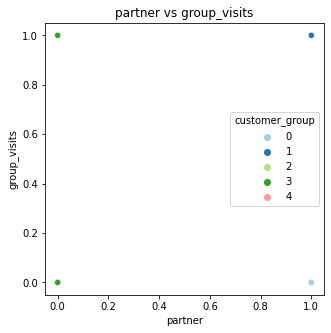

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


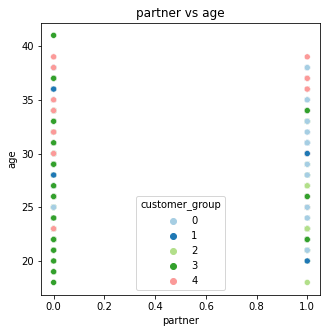

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


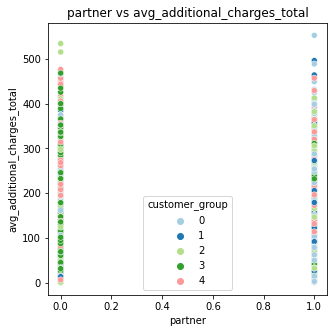

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


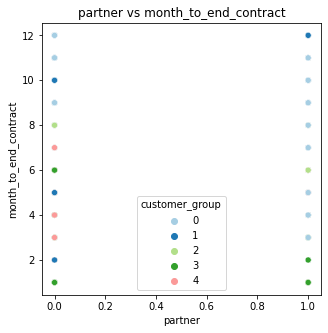

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


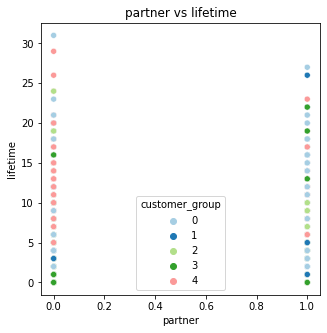

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


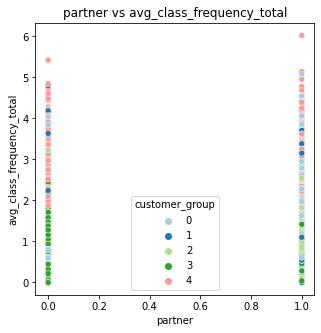

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


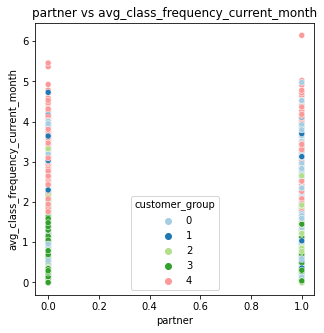

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


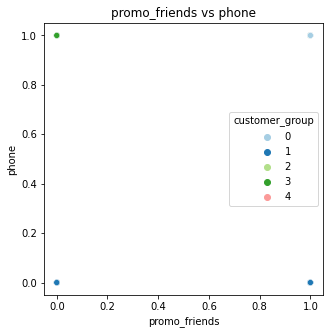

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


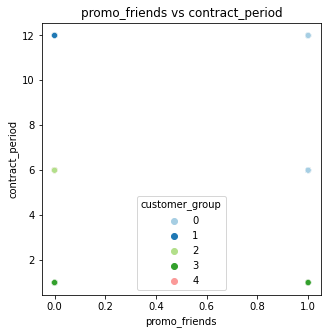

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


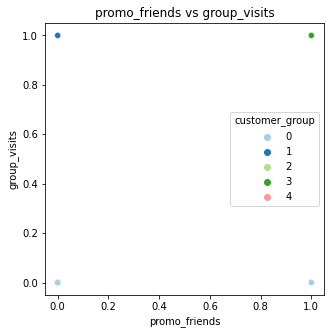

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


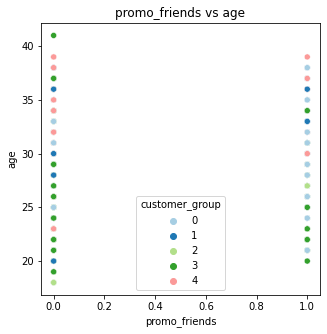

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


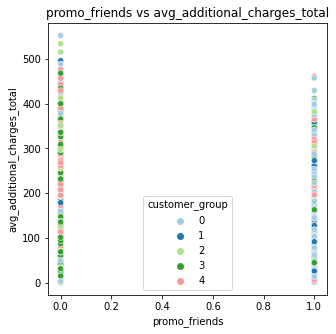

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


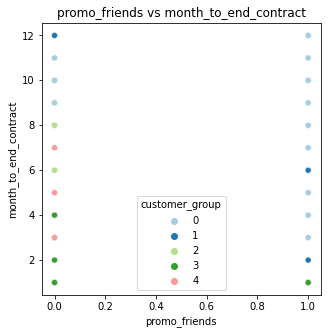

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


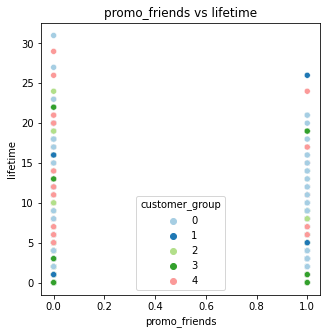

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


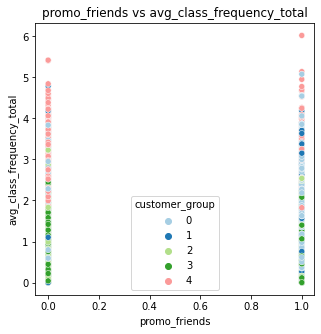

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


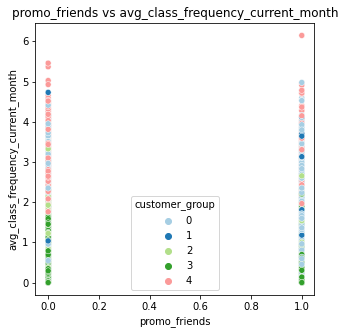

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


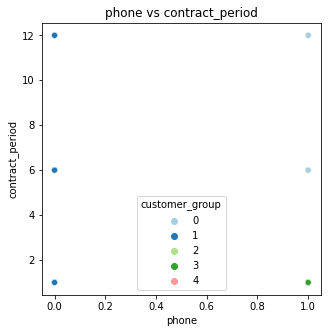

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


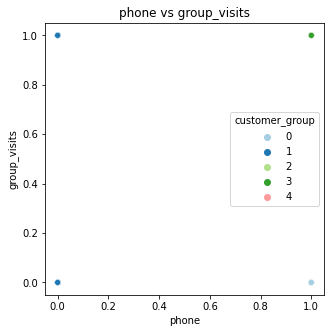

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


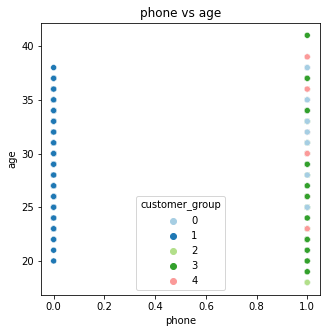

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


In [ ]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show();
    
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(df.drop(['churn', 'customer_group'], axis=1).columns, 2))
for pair in col_pairs:
    show_clusters(df=df, x_name=pair[0], y_name=pair[1], cluster_name='customer_group')

<div style="border:solid green 1px; padding: 10px">
    
У 1 и 5 групп самое высокое среднее значение `lifetime`, у 5 группы также выше, чем у других, среднее по частоте посещений в неделю за все время и за прошлый месяц.

### Доля оттока для кластеров

In [ ]:
# сгруппируем по кластерам и признаку оттока
cust_grp = df.query('churn==1').groupby('customer_group')['churn'].count().reset_index()

# посчитаем долю оттока для каждой группы
share = []

for i in range(len(cust_grp)):
    share.append(round(cust_grp['churn'][i] / df.groupby('customer_group')['churn'].count()[i] * 100, 2))

cust_grp['share'] = share   
cust_grp.sort_values(by='share', ascending=False)

<div style="border:solid green 1px; padding: 10px">

Группы клиентов по доле оттока каждой группы от общего числа оттекших клиентов отличаются довольно сильно:
* самый сильный отток происходит в третьей группе - больше 51%;
* чуть больше 44% у второй группы;
* группа №1 на третьем месте по оттоку - почти 27%;
* в четвертой и пятой отток не столь сильный - ~ 7% и ~3% соответственно (можно считать клиентов в этих группах более надежными).

## Формулировка выводов и разработка рекомендации

<div style="border:solid green 2px; padding: 20px"> Были проверены четыре гипотезы и установлено:

У нас в распоряжении были данные, содержащие информацию о клиентах на месяц до оттока и факт оттока на определённый месяц  такие как пол, возраст, удаленность от дома/работы, среднее количество дней посещения зала в неделю и пр.
    
Всего 4 000 записей о клиентах клуба:

1. В данных есть разделение по признаку оттока (`churn`) клиента:
    - `0` - коиент остался с клубом- 2 939 записей датасета;
    - `1` - клиент перестал посещать клуб - 1 061 запись.

    
2. В зависимости от значения столбца `churn` выявлено следующее распредение:

    - по признаку пола примерно одинаково;
    - по признаку близости от дома/работы сильно выше;
    - сотрудников партнеров клуба больше среди клиентов;
    - клиентов по промо наоборот меньше;
    - очень мало значений с отсутствием телефона клиента;
    - клиенты чаще оформляют месячные абонементы, реже на пол года;
    - клиенты чаще не посещают групповые занятия;
    - пик значений по признаку возраста в районе 30 лет для оставшихся и в районе 27-28 для оттекших;
    - для выручки от сопуствующих услух гистограмма скошена и меет хвост справа;
    - у большинства клиентов до окончания абонемента 1 месяц;
    - по времени от первого обращения в фитнес для оставшихся клиентов пик значения в районе 2 месяцев, для оттекших - одного;
    - по средней частоте посещений в неделю за все время и за прошлый месяц - это 2-3 раза для оставшихся и 1-2 для оттекших, плюс есть небольшой хвост в право.
 
    
3. Есть сильная корреляция признаков `month_to_end_contract` и `contract_period`, а также между `avg_class_frequency_current_month` и `avg_class_frequency_total`, что может быть из-за близости по смыслу. Между остальными признаков сильной зависимости (ни прямой, ни обратной) нет.
    

4. Были построены две модели прогноза вероятности оттока (на уровне следующего месяца) для каждого клиента (логистической регрессии случайного леса) и мы получили почти одинаковый результат: доля верно угаданных ответов (`accuracy`) в 0.90/0.89 для двух моделей, что очень хорошо, первая модель также совсем немного лучше по метрике полноты (`recall`) 0.81 против 0.76.
 
    
5. Мы провели кластеризацию клиентов - разбили их на 5 групп в зависимости от признаков. По средним значениям признаков  среди групп распредение равномерно по полу и возрасту, но по другим признакам есть разница:
    
| группа | расположение | партнер клуба | промо-акция    | срок абонемента | групповые занятия | сопутств. услуги | окончание срока абонемента | с момента обращения месяцев | посещений в неделю (всего) | посещений в неделю (прош.мес.) |
|----------|--------------|----------|----------|-----------------|-------------------|------------------|----------------------------|----------|----------------------------|--------------------------------|
| 1        | 0.959406     | 0.783168 | 0.574257 | 10.889109       | 0.542574          | 160.761016       | 9.954455                   | 4.736634 | 1.982055                   | 1.974789                       |
| 2        | 0.862338     | 0.470130 | 0.306494 | 4.787013        | 0.425974          | 143.957664       | 4.475325                   | 3.924675 | 1.847220                   | 1.716369                       |
| 3        | 0.000000     | 0.463366 | 0.079208 | 2.352475        | 0.215842          | 135.457501       | 2.198020                   | 2.809901 | 1.660461                   | 1.477324                       |
| 4        | 1.000000     | 0.350238 | 0.240095 | 1.948494        | 0.341521          | 131.622204       | 1.856577                   | 2.440571 | 1.247634                   | 1.012983                       |
| 5        | 0.976134     | 0.356802 | 0.230310 | 2.669451        | 0.473747          | 161.657905       | 2.459427                   | 4.898568 | 2.852002                   | 2.850161                       |


**В первой группе** у нас клиенты, для которых клуб расположен достаточно близко, они часто являются сотрудниками партнеров клуба или пришли по промо-акции, абонемент у них, в среднем, больше чем на пол года, они чаще остальных посещают групповые занятия и довольно много тратят на сопутствующие услуги клуба. С момента первого обращения прошло почти 5 месяцев, а до окончания абонементов еще далеко, в среднем около 9 месяцев. Посещают клуб они около двух раз в неделю.

**Во второй группе** клиенты, для которых клуб расположен также достаточно близко, у большинства из них абонемент сроком до 6 месяцев, по потреблению услуг они где-то посередине между всеми группами, до окончания абонемента, в среднем, почти 5 месяцев, а вот с момента обращения прошло почти 4 месяца, менее половины из них посещают групповые, являются сотрудниками партнеров клуба или пришли по промо-акции, посещают зал около 2х раз в неделю.

**В третьей группе** клиенты, которым далеко до клуба добираться, менее половины из них являются сотрудниками партнеров клуба, чаще встречаются месячные абонементы, чем на более длительный срок, они реже остальных ходят на групповые занятия, но сопутствующие услуги потребляют, ходят скорее один раз в неделю, чем больше.

**В четвертой группе** клиенты, наиболее близко работающие/проживающие от клуба, среди них не так много акционных или партнерских, абонементы предпочитают краткосрочные и услугами пользуются меньше всех, группы посещают, но не часто да и в клуб ходят преимущественно раз в неделю.
    
**В пятой группе** клиенты, также базирующиеся недалеко от клуба, не особо часто это партнерские или акционные клиенты, зато среди них чаще попадаются любители абонементов подлиннее или посещающие групповые, у них также выше показатель времени с момента первого обращения и показатель потребления сопуствующих услуг клуба, к тому же они самые частые клиенты клуба по посещениям  - почти 3 раза в неделю.
    
6. Группы клиентов по доле оттока каждой группы от общего числа оттекших клиентов отличаются довольно сильно:

    - самый сильный отток происходит в третьей группе - больше 51%;
    - чуть больше 44% у второй группы;
    - группа №1 на третьем месте по оттоку - почти 27%;
    - в четвертой и пятой отток не столь сильный - ~ 7% и ~3% соответственно (можно считать клиентов в этих группах более надежными).
    
____    
Итак,
    
**для первой группы** картина лояльности где-то посередине (отток 27%), возможно стоит разнообразить групповые, раз они их так любят, или сделать для них закрые VIP-группы, где будет меньше людей, а значит больше внимания к каждому;
    
**для второй группы** по оттоку показатель составляет 44%, у них скоро настанет момент принять решение нужен ли им новый абонемент и возможно стоит предложить им персональную скидку на абонемент сроком от 6 месяцев или на абонемент сроком 1-6 месяцев при условии участия в акции "приведи друга";
    
**по третьей группе** самая сложная ситуация с оттоком - больше 51%, скорее всего это связано с удаленностью клуба от их частого места дислокации, для них возможно предложить тот клуб сети, который к ним ближе (или предложить перейти к партнерам, которые ближе находятся, при условии предварительного участия клиента в акции "приведи друга") или персональные скидки на абонементы сроком больше месяца;
    
**четвертая группа** имеют низкий показатель оттока - 7%, однако клиенты этой группы не сильно активно участвую в жизни клуба, возможно, для них будет актульно предложение скидочных купонов на сопуствующие услуги клуба, тогда, вероятно, они будут чаще посещать зал или групповые занятия, скидки на бонементы также могут быть полезны;
    
**пятая группа** самая надежная по показателю оттока - всего 3%, для них актульным может быть предложение скидок на абонементы или специльные предложения за участие в акции "приведи друга".